# Nimble Quickstart

Nimble is built to find and filter events that meet user specified, multivariate criteria. Once the events are found, it can then return a mask, a Numpy array representation, or a Pandas series representation of the found events that coincides with their location in an array of identical shape to the condition.

Nimble has optional C extensions to return arrays, masks, series and to apply a debounce to events (`Events.as_array()`, `Events.as_series()` and `Events.debounce()`. While there are Python back up functionality to all C implevmentations, it is strongly recomended that you install a C compiler to take advantage of these optimazations, especially if you plan to work with large arrays (500k points and larger) or make use of the `debounce` method. More information on installing a C compiler for Windows can be found here: [https://matthew-brett.github.io/pydagogue/python_msvc.html](https://matthew-brett.github.io/pydagogue/python_msvc.html)

In [21]:
import numpy as np
from nimble import Events
import matplotlib.pyplot as plt
%matplotlib inline

## Getting Started

First, create some fake time series data with a sample period of 1 second.

In [22]:
np.random.seed(2)
x = np.random.randint(0, 2, 25)
y = np.random.randint(2, 5, 25)
sample_period = 1
index = list(range(0, 25))

In [23]:
def plot():
    # Convenience function to plot events vs condition
    plt.plot(index, x, label='condition')
    plt.plot(events.as_array(), label='events', linestyle='--', color='r')
    plt.yticks([-1,0,1,2])
    plt.xlabel('Time(s)')
    plt.ylabel('Value')
    plt.legend()
    plt.xticks(index)
    plt.grid()
    plt.show()

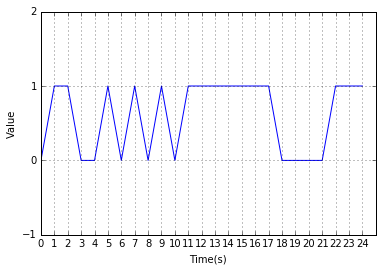

In [24]:
plt.plot(index, x)
plt.yticks([-1,0,1,2])
plt.xlabel('Time(s)')
plt.ylabel('Value')
plt.xticks(index)
plt.grid()
plt.show()

## Basic Usage

Now find the events where x>0. In this case, the events and the condition will be identical arrays.

In [25]:
events = Events(x>0, period=1).find()

One can also convert the found events to a time series array using the `Events.as_array()` method. This is helpful in visualizing your identified events for inspection and troubleshooting.

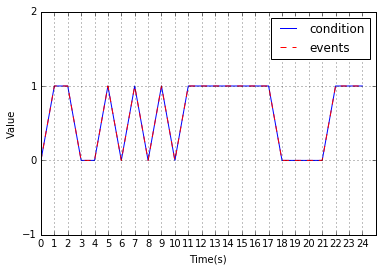

In [26]:
plot()

## Debouncing

Debouncing prevents fast cycling from activating or deactivating events. More information on debouncing can be found in this [Wikipedia](https://en.wikipedia.org/wiki/Switch#Contact_bounce) article

Debounce parameters are specified in the number of consecutive seconds required for the condition to be true or false in order to activate or deactivate an event. Both parameters are inclusive. So if `adeb=4`, then the condition must be true for greater than or equal to 4 seconds to activate an event. If `ddeb=2`, then the condition will need to be `False` for greater than or equal to 2 seconds in order for an activated event to deactivate.

In [27]:
events = Events(x>0, period=1, 
                adeb=1, ddeb=2).find()

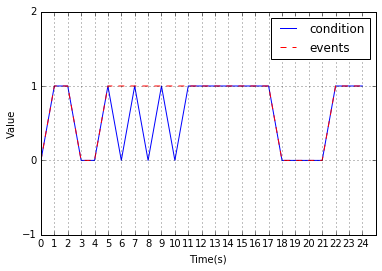

In [28]:
plot()

## Event Duration Filtering

Event's can be filtered out by both their minimum and maximum durations. Again, these parameters are inclusive. So if `mindur=3`, then any event greater than or equal to 3 seconds will not be excluded. If `maxdur=5`, then any event less than or equal to 5 seconds in duration will not be excluded

In [29]:
events = Events(x>0, period=1, mindur=3, maxdur=5).find()

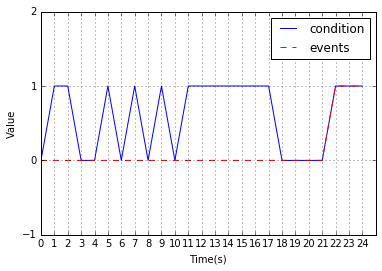

In [30]:
plot()

## Offsetting Event Start and Stop Values

The start and stop locations of any identified events can be directly manipulated by the user. This can be helpful to determine what may or may not be happening in the time leading up to an event or following an event. These parameters are specified in seconds. 

> **Note**: startoffset must be a negative number, and stopoffset must be a positive number.

In [31]:
events = Events(x>0, period=1, ddeb=2, 
                mindur=3, startoffset=-1, stopoffset=1).find()

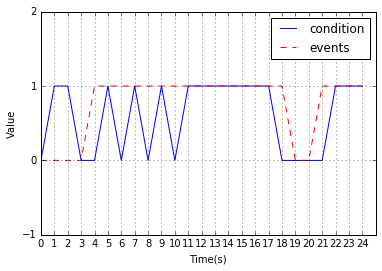

In [32]:
plot()

## A Note on Execution Order and the `find()` Method

The `Events.find()` method is a convenience method that applies filters in the following order:

1. `apply_condition()` 
2. `debounce()`
3. `filter_durations()`
4. `offset()`

It returns self, which allows it to be called inline with the class instantiation, or at a later time if desired.

> **Note**: The decorator function `skip_check()` prevents unnecessary applications of the above filters if there are no events or their respective parameters aren't specified by the user.

To apply a custom order one can apply the filters above in their desired order, or you could inherit from `Events` and override the `find()` method.

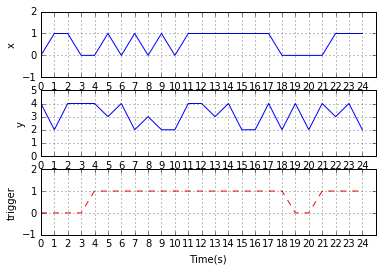

In [33]:
plt.subplot(3,1,1)
plt.plot(index, x, label='x')
plt.ylabel('x')
plt.yticks([-1,0,1,2])
plt.xticks(index)
plt.grid()

plt.subplot(3,1,2)
plt.plot(index, y, label='y')
plt.ylabel('y')
plt.yticks(list(range(6)))
plt.xticks(index)
plt.grid()

plt.subplot(3,1,3)
plt.plot(events.as_array(), label='trigger', linestyle='--', color='r')
plt.yticks([-1,0,1,2])
plt.xlabel('Time(s)')
plt.ylabel('trigger')
plt.xticks(index)
plt.grid()

plt.show()

## Iterating Over Events

The `Events` class is also an iterable, allowing the user to easily inspect each identified event.

When iterating, the following attributes become available:

1. `i` - Counter to determine what event you're analyzing (zero start)
2. `istart` - Returns the index number at the start of the event
3. `istop` - Returns the index number at the end of the event
4. `iduration` - Returns the duration in seconds of the event
5. `islice` - Returns the slice for the event (useful for slicing over arrays)



In [34]:
string=('For event {}, y[istart] and y[istop] is {} & {}, \n'
        'and the average of y during the event is {:.2f} \n')
for event in events:
    print(string.format(event.i, y[event.istart], y[event.istop], 
                        np.mean(x[event.islice]), event.i))

For event 0, y[istart] and y[istop] is 4 & 2, 
and the average of y during the event is 0.67 

For event 1, y[istart] and y[istop] is 4 & 2, 
and the average of y during the event is 0.75 



## Special Methods of `Events`

### The `__len__()` special method

The function `len(events)` tells you how many events were found

In [35]:
print('There were {} events identified'.format(len(events)))

There were 2 events identified


### The `__str__()` special method

You can get a quick summary of all of the events by doing `print()`

In [36]:
print(events)

Number of events: 2
Min, Max, Mean Duration: 4.000s, 15.000s, 9.500s
period: 1s,
adeb: None, ddeb: 2s,
mindur: 3s, maxdur: None,
startoffset: -1s, stopoffset: 1s


### The `__eq__()` special method

Two `Events` objects can be directly compared. To be a match, the `_starts`, `_stops`, `period` and `condition.size` must be identical.

In [37]:
events == events

True

## Multivariate Conditions

You're not limited to one condition. To create multivariate events, just enclose each condition in `()` and make use of `&` (and) and the `|` (or) operators.

In [38]:
events = Events((x>0) & (y>3), period=1, 
                ddeb=2, mindur=3, 
                startoffset=-1, stopoffset=1).find()

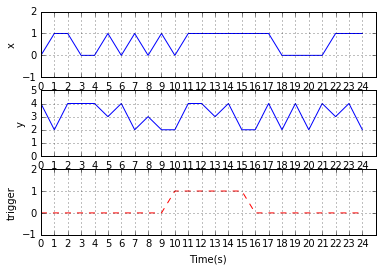

In [39]:
plt.subplot(3,1,1)
plt.plot(index, x, label='x')
plt.ylabel('x')
plt.yticks([-1,0,1,2])
plt.xticks(index)
plt.grid()

plt.subplot(3,1,2)
plt.plot(index, y, label='y')
plt.ylabel('y')
plt.yticks(list(range(6)))
plt.xticks(index)
plt.grid()

plt.subplot(3,1,3)
plt.plot(events.as_array(), label='trigger', linestyle='--', color='r')
plt.yticks([-1,0,1,2])
plt.xlabel('Time(s)')
plt.ylabel('trigger')
plt.xticks(index)
plt.grid()

plt.show()

## Quickstart

A quickstart jupyter notebook has been provided in the install directory.

In [40]:
import inspect
import nimble
import os
path_to_init = inspect.getfile(nimble)
install_dir = os.path.dirname('z:\\nimble\\nimble\\__init__.py')
path_to_qs = os.path.join(install_dir, 'Nimble_Quickstart.pynb')
print(path_to_qs)

z:\nimble\nimble\Nimble_Quickstart.pynb
